In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../../data_process/')
from my_data_pre_intdash import DataPre

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
def loadRealData(dsint32, dsint64, dsdash32, dsdash64, num_cols, cat_cols, sample_size, seq_len, randon, outliers):
    dp = DataPre()
    dp.loadDataSet(path32_int=dsint32, path64_int=dsint64, path32_dash=dsdash32, path64_dash=dsdash64)
    
    dp.preProcessData(num_cols, cat_cols=cat_cols, cond_col='q_size', random=randon)
    if outliers == False:
        dp.removeOutliers()
    
    real_data_32 = dp.processed_data.loc[dp.processed_data['q_size'] == 0].copy()
    real_data_32 = real_data_32[0:sample_size].copy()
    real_data_32.drop(columns=['q_size'], inplace=True)
    real_data_32.drop(columns=[' enq_qdepth2'], inplace=True)
    real_data_32.drop(columns=[' deq_qdepth2'], inplace=True)
    real_data_32.drop(columns=['enq_qdepth3'], inplace=True)
    real_data_32.drop(columns=['deq_qdepth3'], inplace=True)
    
    
    real_data_32 = real_data_loading(real_data_32.values, seq_len=seq_len)
    
    real_data_64 = dp.processed_data.loc[dp.processed_data['q_size'] == 1].copy()
    real_data_64 = real_data_64[0:sample_size].copy()
    real_data_64.drop(columns=['q_size'], inplace=True)
    real_data_64.drop(columns=[' enq_qdepth2'], inplace=True)
    real_data_64.drop(columns=[' deq_qdepth2'], inplace=True)
    real_data_64.drop(columns=['enq_qdepth3'], inplace=True)
    real_data_64.drop(columns=['deq_qdepth3'], inplace=True)
    
    real_data_64 = real_data_loading(real_data_64.values, seq_len=seq_len)
    
    return real_data_32, real_data_64

In [20]:
def loadSynthData(path32, path64, sample_size, seq_len):
    
    df32 = pd.read_csv(path32, sep = ',')
    df64 = pd.read_csv(path64, sep = ',')
    
    synth_data_32 = df32[0:sample_size].copy()
    synth_data_32.drop(columns=['q_size'], inplace=True)
    synth_data_32.drop(columns=[' enq_qdepth2'], inplace=True)
    synth_data_32.drop(columns=[' deq_qdepth2'], inplace=True)
    synth_data_32.drop(columns=['enq_qdepth3'], inplace=True)
    synth_data_32.drop(columns=['deq_qdepth3'], inplace=True)
    
    
    synth_data_32 = real_data_loading(synth_data_32.values, seq_len=seq_len)
    

    synth_data_64 = df64[0:sample_size].copy()
    synth_data_64.drop(columns=['q_size'], inplace=True)
    synth_data_64.drop(columns=[' enq_qdepth2'], inplace=True)
    synth_data_64.drop(columns=[' deq_qdepth2'], inplace=True)
    synth_data_64.drop(columns=['enq_qdepth3'], inplace=True)
    synth_data_64.drop(columns=['deq_qdepth3'], inplace=True)
    
    
    synth_data_64 = real_data_loading(synth_data_64.values, seq_len=seq_len)
    
    return synth_data_32, synth_data_64

In [21]:
def createPCA_TNSE(real, synt, clas, sample_size, seq_len):
    idx = np.random.permutation(len(real))[:sample_size]
    
    n_components = 2
    pca = PCA(n_components=n_components)
    tsne = TSNE(n_components=n_components, n_iter=300)
    
    real_sample = np.asarray(real)[idx]
    synthetic_sample = np.asarray(synt)[idx]


    real_data_reduced = real_sample.reshape(-1, seq_len)
    synth_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)
    #The fit of the methods must be done only using the real sequential data
    pca.fit(real_data_reduced)

    pca_real = pd.DataFrame(pca.transform(real_data_reduced))
    pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

    data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)
    tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))
    
    fig = plt.figure(constrained_layout=True, figsize=(10,5))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    #TSNE scatter plot
    ax = fig.add_subplot(spec[0,0])
    ax.set_title('PCA results',
                fontsize=20,
                color='green',
                pad=10)

    #PCA scatter plot
    plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
                c='black', alpha=0.2, label='Original')
    plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
                c='green', alpha=0.2, label='Synthetic')
    ax.legend()

    """ ax2 = fig.add_subplot(spec[0,1])
    ax2.set_title('TSNE results',
                fontsize=20,
                color='green',
                pad=10)

    plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
                c='black', alpha=0.2, label='Real')
    plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
                c='green', alpha=0.2, label='Synth') 

    ax2.legend()"""

    #fig.suptitle('Validating synthetic vs real data diversity and distributions', fontsize=16, color='grey')

In [22]:
num_cols = ['enq_qdepth1','deq_timedelta1', 'deq_qdepth1',
            ' enq_qdepth2', ' deq_timedelta2', ' deq_qdepth2',
            'enq_qdepth3', 'deq_timedelta3', 'deq_qdepth3',
            'Buffer', 'ReportedBitrate', 'FPS', 'CalcBitrate',
            'q_size'] 

real_32, real_64 = loadRealData(dsint32='../../datasets/log_INT_TD-32_100.txt',
                                dsint64= '../../datasets/log_INT_TD-64_100.txt',
                                dsdash32='../../datasets/dash_TD-32_100.txt',
                                dsdash64='../../datasets/dash_TD-64_100.txt',
                                num_cols=num_cols,
                                cat_cols=[],
                                sample_size=4000,
                                seq_len=50,
                                randon=False, 
                                outliers=False) 

In [23]:
synth_32_best, synth_64_best = loadSynthData('synth_ds/models9_50_3600_norm/best_modelsum_32.csv', 'synth_ds/models9_50_3600_norm/best_modelsum_64.csv', 5000, 50)
synth_32_worst, synth_64_worst = loadSynthData('synth_ds/models9_50_3600_norm/worst_modelsum_32.csv', 'synth_ds/models9_50_3600_norm/worst_modelsum_64.csv', 5000, 50)


In [24]:
real_32 = np.asarray(real_32)
synth_32_best = np.asarray(synth_32_best)

In [25]:
synth_32_best.shape

(3550, 50, 9)

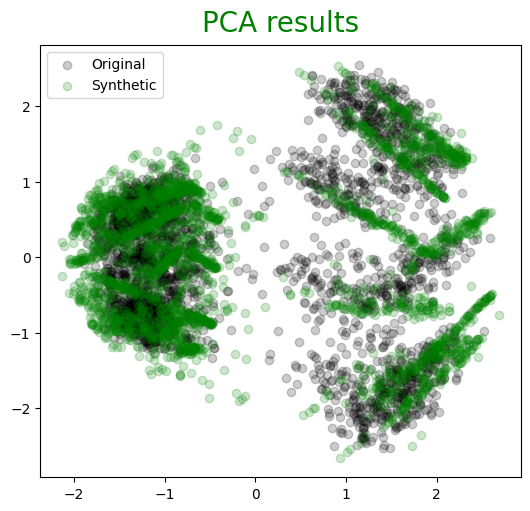

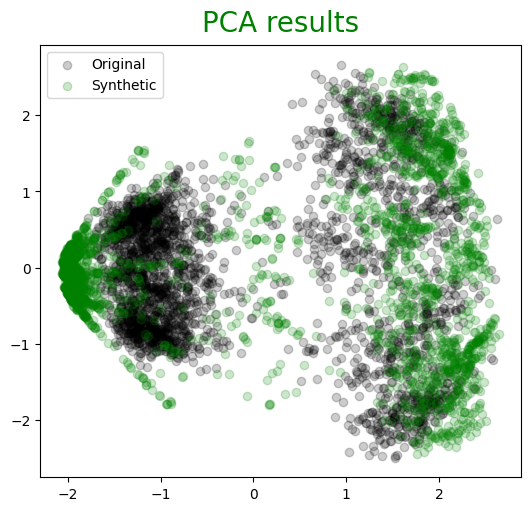

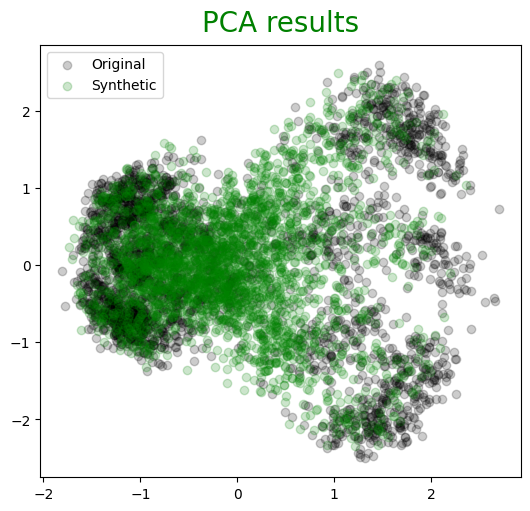

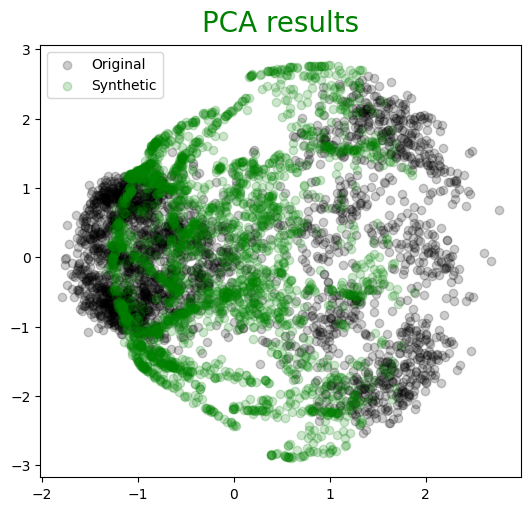

In [32]:
createPCA_TNSE(real_32, synth_32_best, '32', 300, 50)
createPCA_TNSE(real_32, synth_32_worst, '32', 300, 50)
createPCA_TNSE(real_64, synth_64_best, '64', 300, 50)
createPCA_TNSE(real_64, synth_64_worst, '64', 300, 50)

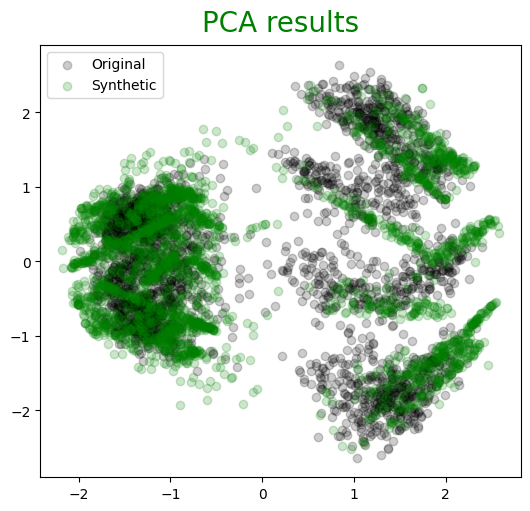

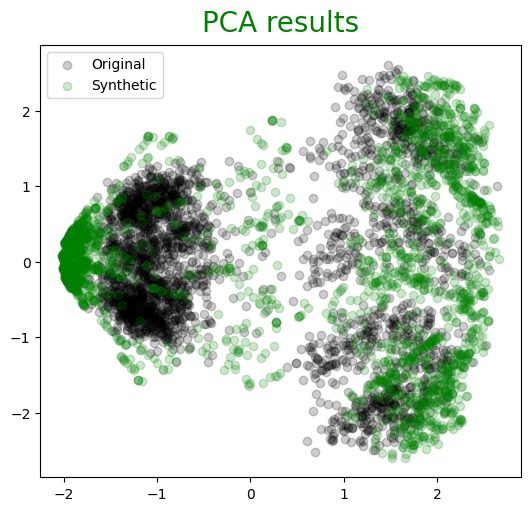

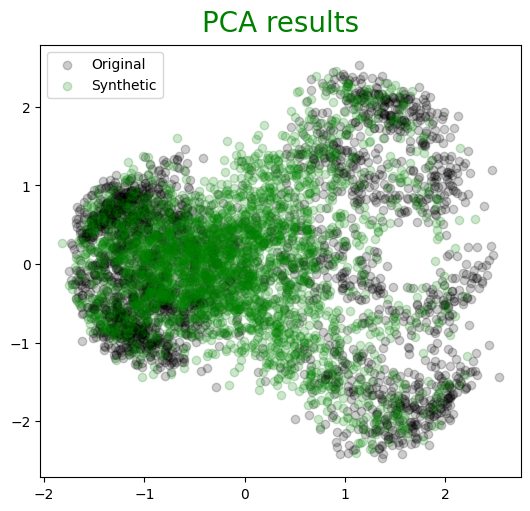

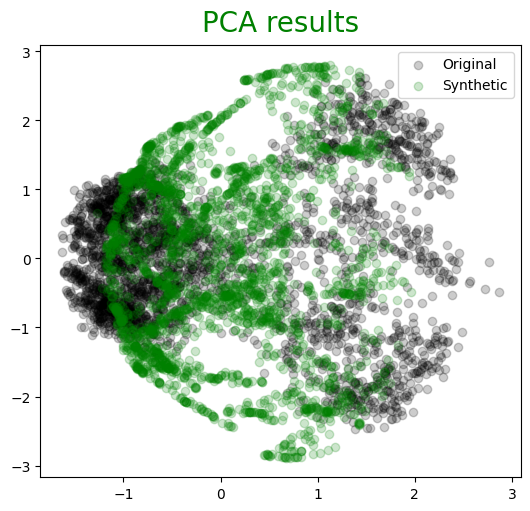

In [28]:
synth_32_best, synth_64_best = loadSynthData('synth_ds/models9_50_imp/best_models_32.csv', 'synth_ds/models9_50_imp/best_feats_64.csv', 5000, 50)
synth_32_worst, synth_64_worst = loadSynthData('synth_ds/models9_50_imp/worst_models_32.csv', 'synth_ds/models9_50_imp/worst_models_64.csv', 5000, 50)
createPCA_TNSE(real_32, synth_32_best, '32', 300, 50)
createPCA_TNSE(real_32, synth_32_worst, '32', 300, 50)
createPCA_TNSE(real_64, synth_64_best, '64', 300, 50)
createPCA_TNSE(real_64, synth_64_worst, '64', 300, 50)

IndexError: index 9 is out of bounds for axis 1 with size 9

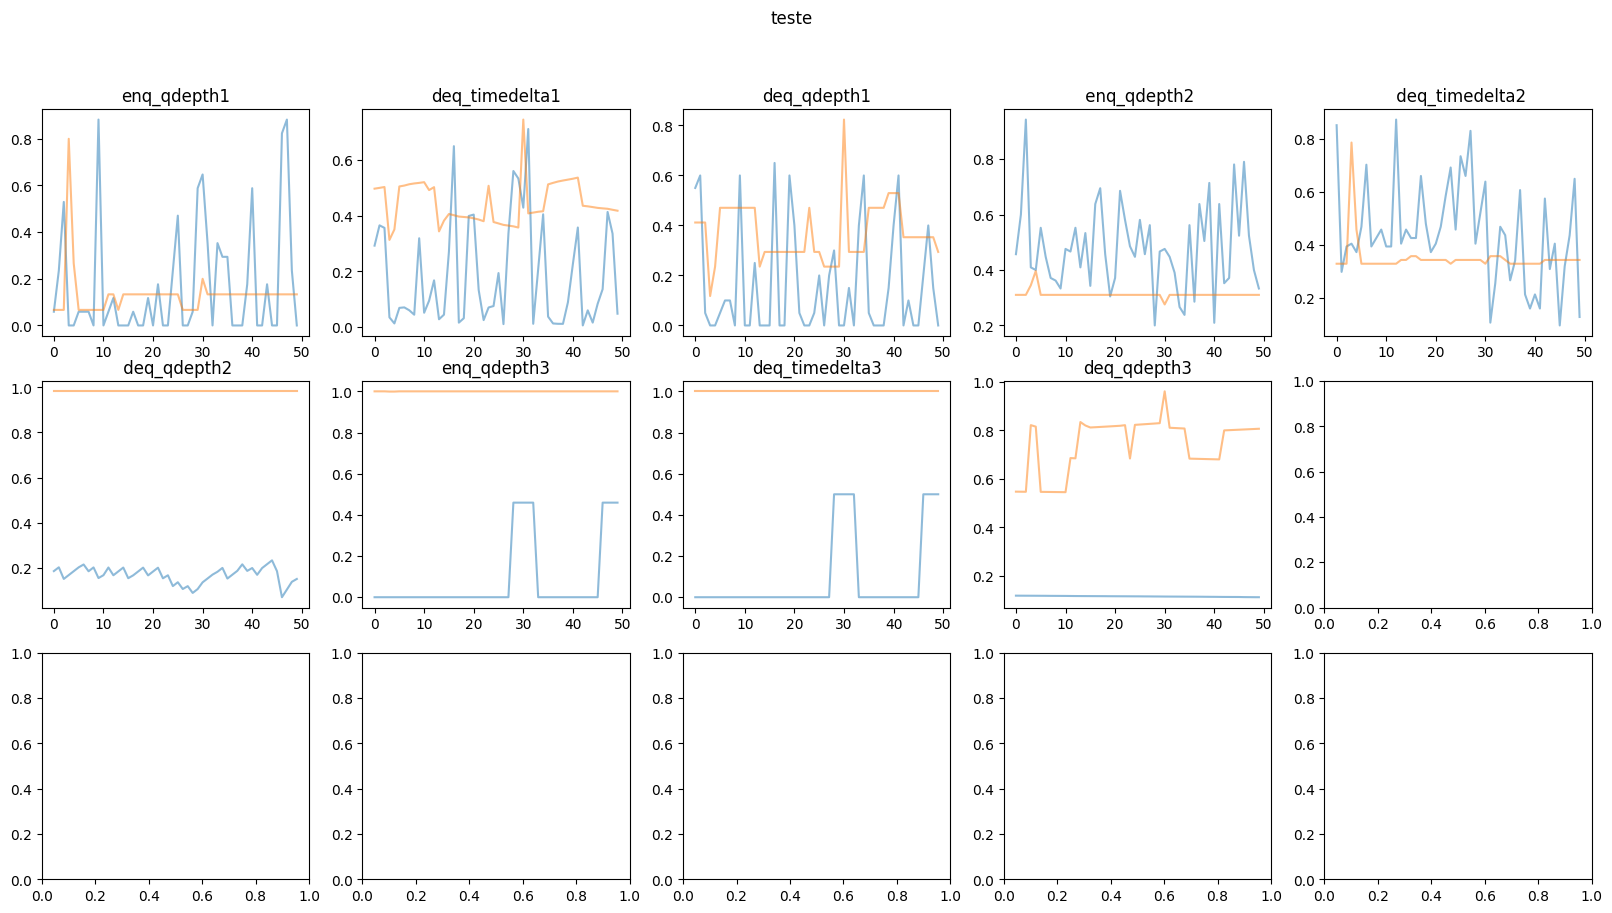

In [29]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle("teste")
axes = axes.flatten()

num_cols = ['enq_qdepth1','deq_timedelta1', 'deq_qdepth1',
            ' enq_qdepth2', ' deq_timedelta2', ' deq_qdepth2',
            'enq_qdepth3', 'deq_timedelta3', 'deq_qdepth3',
            'Buffer', 'ReportedBitrate', 'FPS', 'CalcBitrate'] 

for j, col in enumerate(num_cols): 
    #axes[j].set_ylim([-0.1, 1.1])
    axes[j].plot(real_32[0][:,j][:2000], alpha=0.5, label=('Real'))
    axes[j].plot(synth_32_best[0][:,j][:2000], alpha=0.5, label=('Synth'))
    axes[j].set_title(col)

fig.tight_layout()

In [30]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=14,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [31]:
#Prepare the dataset for the regression model
seq_len = 50

real_data = np.asarray(real_32)
synth_data = synth_32_best[:len(real_data)]
n_events = len(real_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_real_train = real_data[train_idx, :seq_len-1, 0:14]
X_synth_train = synth_data[train_idx, :seq_len-1, 0:14]

X_real_test = real_data[test_idx, :seq_len-1, 0:14]
y_real_test = real_data[test_idx, -1, 0:14]

#Define the y for synthetic and real datasets
y_stock_train = real_data[train_idx, -1, 0:14]
y_synth_train = synth_data[train_idx, -1, 0:14]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_real_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_real_test.shape))
print('Real y test: {}'.format(y_real_test.shape))

TypeError: list indices must be integers or slices, not tuple